In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# calculations for thermodynamics
from metpy.calc import thermo
from metpy.units import units

In [2]:
# importing theta_calc module
sys.path.append('/neelin2020/mcs_flextrkr/scripts/modules')
from theta_e_calc_mod import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def thetae_calc_layer(T, q, sp, T2m, q2m):
    """
    function for calcultinig the low-trospospheric buoyancy estimates
    T, q : 3D xarray dataarray (level, lat, lon)
    sp: surface pressure (lat, lon), unit: hPa
    T2m, q2m: temperature, specific humidity at 2m (lat, lon)
    """

    T = T
    q = q
    T2m = T2m
    q2m = q2m
    sp = sp

    # constants
    Lv = 2.5e6 # (J/kg)
    g = 9.81 # (kg/m^2)
    cpd = 1004 # (J/kg/K)
    p0 = 1000  # (hPa)
    Rd = 287.15 # (J/kg)

    # find pbl top (100 hPa above the surface)
    pbl_top_level = find_pbl_top_level_latlon(sp, T, pbl_depth=100)

    thetae_bl_list = []
    thetae_lt_list = []
    thetae_sat_lt_list = []

    # loop for lat-lon grids
    for idx_lat in range(len(q2m.latitude)):
        for idx_lon in range(len(q2m.longitude)):

            #try:
            sf_p = sp.isel(latitude=idx_lat, longitude=idx_lon) # surface pressure
            pbl_p = pbl_top_level.isel(latitude=idx_lat, longitude=idx_lon).pbl_top_level.values # pbl top pressure
            T_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

            T_at_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_at_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

            T_above_sf = T.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values
            q_above_sf = q.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values

            # reconstruct T, q profile by adding surface quantities
            T_1d = np.concatenate([np.array([T_at_sf]), np.flip(T_above_sf)])
            q_1d = np.concatenate([np.array([q_at_sf]), np.flip(q_above_sf)])
            pressure_1d = np.concatenate([np.array([sf_p]), np.flip(T.sel(level=slice(100,int(sf_p))).level.values)])
            T_1d_xr = xr.DataArray(data=T_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))
            q_1d_xr = xr.DataArray(data=q_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))

            # splitting into boundary layer and lower free troposphere
            # 1. boundary layer, bl
            q_bl = q_1d_xr.sel(level=slice(int(sf_p), pbl_p))
            T_bl = T_1d_xr.sel(level=slice(int(sf_p), pbl_p))
            # 2. lower free troposphere, lt
            q_lt = q_1d_xr.sel(level=slice(pbl_p,500))
            T_lt = T_1d_xr.sel(level=slice(pbl_p,500))

            # calculating layer-averaged thetae components
            thetae_bl = theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1]) # negative sign b.c. decreasing p
            thetae_lt = theta_e_calc(T_lt, q_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])
            qsat_lt = qs_calc(T_lt)
            thetae_sat_lt = theta_e_calc(T_lt, qsat_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])

            thetae_bl_list.append(thetae_bl.values)
            thetae_lt_list.append(thetae_lt.values)
            thetae_sat_lt_list.append(thetae_sat_lt.values)

            #except:
                
            #    thetae_bl_list.append(np.nan)
            #    thetae_lt_list.append(np.nan)
            #    thetae_sat_lt_list.append(np.nan)

    # convert to geolocated xarray
    thetae_bl_xr = xr.DataArray(data = np.asarray(thetae_bl_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["lat",'lon'],
                               coords = dict(lat=(["lat"], T.latitude.values),
                                           lon=(["lon"], T.longitude.values)),
                               attrs=dict(description = "theta_e averaged from surface to 100 mb up"))
                               
    thetae_lt_xr = xr.DataArray(data = np.asarray(thetae_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["lat",'lon'],
                               coords = dict(lat=(["lat"], T.latitude.values),
                                           lon=(["lon"], T.longitude.values)),
                               attrs=dict(description = "theta_e averaged from 100 mb above surface to 500 mb"))
    
    thetae_sat_lt_xr = xr.DataArray(data = np.asarray(thetae_sat_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["lat",'lon'],
                               coords = dict(lat=(["lat"], T.latitude.values),
                                           lon=(["lon"], T.longitude.values)),
                               attrs=dict(description = "SATURATED theta_e averaged from 100 mb above surface to 500 mb"))
    # calculate buoyancy estimates
    # 2-d weighting parameters for pbl and lt
    #delta_pl=sp-100-500
    #delta_pb=100
    #wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    #wl=1-wb

    # calculate buoyancy estimate
    #Buoy_CAPE = (9.81/(340*3)) * wb * ((thetae_bl_xr-thetae_sat_lt_xr)/thetae_sat_lt_xr) * 340
    #Buoy_CAPE_xr = Buoy_CAPE.rename('Buoy_CAPE').to_dataset()
    #Buoy_SUBSAT = (9.81/(340*3))* wl * ((thetae_sat_lt_xr-thetae_lt_xr)/thetae_sat_lt_xr) * 340
    #Buoy_SUBSAT_xr = Buoy_SUBSAT.rename('Buoy_SUBSAT').to_dataset()
    #Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT
    #Buoy_TOT_xr = Buoy_TOT.rename('Buoy_TOT').to_dataset()

    thetae_bl_xr  = thetae_bl_xr.rename('thetae_bl').to_dataset()
    thetae_lt_xr  = thetae_lt_xr.rename('thetae_lt').to_dataset()
    thetae_sat_lt_xr  = thetae_sat_lt_xr.rename('thetae_sat_lt').to_dataset()

    return xr.merge([thetae_bl_xr, thetae_lt_xr, thetae_sat_lt_xr])

In [ ]:
%%time
# read era5 3-D variables under /neelin2020/ERA-5/NC_FILES
# saved as era5_2layers_thetae_2006_04_20.nc

year = 2002
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}'.format(year))
T = xr.open_dataset(era5_dir / 'era-5.T.2002.01.nc').isel(time=0).sel(latitude=slice(35,-35)).t.compute()
q = xr.open_dataset(era5_dir / 'era-5.q.2002.01.nc').isel(time=0).sel(latitude=slice(35,-35)).q.compute()
sp = (xr.open_dataset(era5_dir / 'era-5.sp.2002.01.nc').isel(time=0).sel(latitude=slice(35,-35)).SP/100).compute() # hPa
T2m = xr.open_dataset(era5_dir / 'era-5.2t.2002.01.nc').isel(time=0).sel(latitude=slice(35,-35)).VAR_2T.compute()
d2m = xr.open_dataset(era5_dir / 'era-5.2d.2002.01.nc').isel(time=0).sel(latitude=slice(35,-35)).VAR_2D.compute()
q2m = thermo.specific_humidity_from_dewpoint(sp*100 * units.pascal, d2m * units.kelvin).compute()

# constants
Lv = 2.5e6 # (J/kg)
g = 9.81 # (kg/m^2)
cpd = 1004 # (J/kg/K)
p0 = 1000  # (hPa)
Rd = 287.15 # (J/kg)

# find pbl top (100 hPa above the surface)
pbl_top_level = find_pbl_top_level_latlon(sp, T, pbl_depth=100)

thetae_bl_map = np.zeros((len(T.latitude),len(T.longitude)))
thetae_lt_map = np.copy(thetae_bl_map)
thetae_sat_lt_map = np.copy(thetae_bl_map)

In [ ]:
%%time
# loop for lat-lon grids
for idx_lat in range(len(q2m.latitude)):
    for idx_lon in range(len(q2m.longitude)):

        #try:
        sf_p = sp.isel(latitude=idx_lat, longitude=idx_lon).values # surface pressure
        pbl_p = pbl_top_level.isel(latitude=idx_lat, longitude=idx_lon).pbl_top_level.values # pbl top pressure
        
        if pbl_p > 500: # only if pbl_p < 500 hPa (avoid mountains):

            T_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

            T_at_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_at_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

            T_above_sf = T.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values
            q_above_sf = q.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values

            # reconstruct T, q profile by adding surface quantities
            T_1d = np.concatenate([np.array([T_at_sf]), np.flip(T_above_sf)])
            q_1d = np.concatenate([np.array([q_at_sf]), np.flip(q_above_sf)])
            pressure_1d = np.concatenate([np.array([sf_p]), np.flip(T.sel(level=slice(100,int(sf_p))).level.values)])
            T_1d_xr = xr.DataArray(data=T_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))
            q_1d_xr = xr.DataArray(data=q_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))

            # splitting into boundary layer and lower free troposphere
            # 1. boundary layer, bl
            q_bl = q_1d_xr.sel(level=slice(int(sf_p), pbl_p))
            T_bl = T_1d_xr.sel(level=slice(int(sf_p), pbl_p))
            # 2. lower free troposphere, lt
            q_lt = q_1d_xr.sel(level=slice(pbl_p,500))
            T_lt = T_1d_xr.sel(level=slice(pbl_p,500))

            # calculating layer-averaged thetae components
            thetae_bl = -theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1]) # negative sign b.c. decreasing p
            thetae_lt = -theta_e_calc(T_lt, q_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])
            qsat_lt = qs_calc(T_lt)
            thetae_sat_lt = -theta_e_calc(T_lt, qsat_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])

            thetae_bl_map[idx_lat,idx_lon] = thetae_bl.values
            thetae_lt_map[idx_lat,idx_lon] = thetae_lt.values
            thetae_sat_lt_map[idx_lat,idx_lon] = thetae_sat_lt.values
            
        else: # moutain areas
            
            thetae_bl_map[idx_lat,idx_lon] = np.nan
            thetae_lt_map[idx_lat,idx_lon] = np.nan
            thetae_sat_lt_map[idx_lat,idx_lon] = np.nan

# convert to geolocated xarray
thetae_bl_xr = xr.DataArray(data = thetae_bl_map,
                           dims = ["lat",'lon'],
                           coords = dict(lat=(["lat"], T.latitude.values),
                                       lon=(["lon"], T.longitude.values)),
                           attrs=dict(description = "theta_e averaged from surface to 100 mb up"))

thetae_lt_xr = xr.DataArray(data = thetae_lt_map,
                           dims = ["lat",'lon'],
                           coords = dict(lat=(["lat"], T.latitude.values),
                                       lon=(["lon"], T.longitude.values)),
                           attrs=dict(description = "theta_e averaged from 100 mb above surface to 500 mb"))

thetae_sat_lt_xr = xr.DataArray(data = thetae_sat_lt_map,
                           dims = ["lat",'lon'],
                           coords = dict(lat=(["lat"], T.latitude.values),
                                       lon=(["lon"], T.longitude.values)),
                           attrs=dict(description = "SATURATED theta_e averaged from 100 mb above surface to 500 mb"))

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

cp = ax.pcolormesh(thetae_bl_xr.lon, thetae_bl_xr.lat, thetae_bl_xr, transform=ccrs.PlateCarree())
plt.colorbar(cp,ax=ax,shrink=0.3)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [ ]:
# calculating layer-averaged thetae components
thetae_bl = -theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1]) # negative sign b.c. decreasing p
thetae_lt = -theta_e_calc(T_lt, q_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])
qsat_lt = qs_calc(T_lt)
thetae_sat_lt = -theta_e_calc(T_lt, qsat_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])

In [ ]:
tmp = -theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1])

In [15]:
data = xr.open_dataset('/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_2002_01_01.nc')
thetae_sat_lt = data.isel(time=0).thetae_sat_lt
thetae_lt = data.isel(time=0).thetae_lt
bl_subsat = (thetae_lt - thetae_sat_lt)/thetae_sat_lt*340

data_gpm = xr.open_dataset('/neelin2020/RGMA_feature_mask/GPM_ncfiles_2002/GPM_IMERGE_V06_20020101_0000.nc')
precip = data_gpm.isel(time=0).precipitationCal.sel(lat=slice(-30,30))

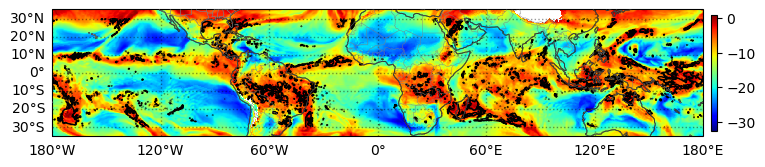

In [24]:
fig,ax = plt.subplots(1,1, figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

cp = ax.pcolormesh(bl_subsat.lon, bl_subsat.lat, bl_subsat, cmap='jet', transform=ccrs.PlateCarree())
plt.colorbar(cp,ax=ax,shrink=0.5, pad=0.01)
ax.contour(precip.lon, precip.lat, precip.T, levels=[0.5], colors=['k'], linewidths=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER